In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, cross_val_score
import os
from itertools import cycle
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
import seaborn as sns
import numpy.random as nr

In [3]:
import zipfile
with zipfile.ZipFile('consumer_complaints.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
Data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')

<ipython-input-4-e8779834b69f>:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv('consumer_complaints.csv', encoding='latin-1')


In [5]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

<ipython-input-5-defa6ba9722b>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
Data

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555952,07/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NaN,NaN,NaN,NaN,Referral,07/07/2014,Closed with explanation,Yes,No,919529
555953,07/01/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Residential Credit Solutions,NaN,NaN,"Older American, Servicemember",NaN,Referral,07/23/2014,Closed with explanation,No,No,918447
555954,07/10/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,BB&T Financial,NaN,NaN,NaN,NaN,Phone,11/18/2013,Closed with explanation,Yes,No,114550
555955,04/14/2015,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,Global Recovery Group,NaN,NaN,NaN,NaN,Phone,04/14/2015,Untimely response,No,No,1329963


In the above data we have to just classify products based on narrative given by customers so, we need 2 column i.e. `product` and `consumer_complaint_narrative`

## Data understanding 

In [7]:
Data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                    int64 
dtype: object

In [8]:
pd.notnull(Data['consumer_complaint_narrative']).value_counts()

False    489151
True     66806 
Name: consumer_complaint_narrative, dtype: int64

Take data which contain atleast 1 word which is to useful while model building, From the above output it shows `66806` are not null rows so we have to take only those rows. 

In [9]:
Data = Data[['product','consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
Data

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n
190135,Consumer Loan,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX XXXX 2015, there was a delinquent balance of {$1400.00}. The monies from the GAP insurance and my insurance company has been paid, M & T Bank says that I still owe {$620.00}, of which {$210.00} has already been paid. I contacted M & T Bank via return receipt mail, but I have not been given the courtesy of a response yet. \n"
190155,Mortgage,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork began to be processed for some kind of approval. In XX/XX/XXXX I was in a trial period of 3 months of payments based on a slightly modified amount. Roughly {$75.00} less than what I was paying on my original payment. However, my caseworker with WFB, failed to tell me that since the payments during this time were not the full amount of the original mortgage payment so they were not applied to the loan. I discovered this in XX/XX/XXXX when I was told by a creditor with XXXX that she could n't restore my line of credit because of something to do with my mortgage. I then called and found this out. My caseworker at WFB then told me it was n't her responsibility to tell me this information. I told her that she could have told me that if I could come up with the remaining amount of {$75.00} then the payments would be applied. Instead, she chose to withhold this information and damage my credit even further. Now we are into 5 months ( including the 90 days WFB told me I had to fall behind until they would help me ) without an applied payment to my home loan, going on 6 months. \nMore paperwork was lost in XXXX as the modification was being finalized and my loan modification did n't go through until XX/XX/XXXX. I spoke to a lawyer that is working on a class-action laws

In [10]:
Data.shape

(66806, 2)

In [11]:
# check the distribution of complaint by category
Data.groupby('product').consumer_complaint_narrative.count()

product
Bank account or service    5711 
Consumer Loan              3678 
Credit card                7929 
Credit reporting           12526
Debt collection            17552
Money transfers            666  
Mortgage                   14919
Other financial service    110  
Payday loan                726  
Prepaid card               861  
Student loan               2128 
Name: consumer_complaint_narrative, dtype: int64

**Note:** Imbalance Dataset, `Other financial service`, `Money transfers`, `Payday loan`, `Prepaid card` are having less than `1000` rows denoting imbalance dataset

Let's Analyse it Graphically

## Splitting the data

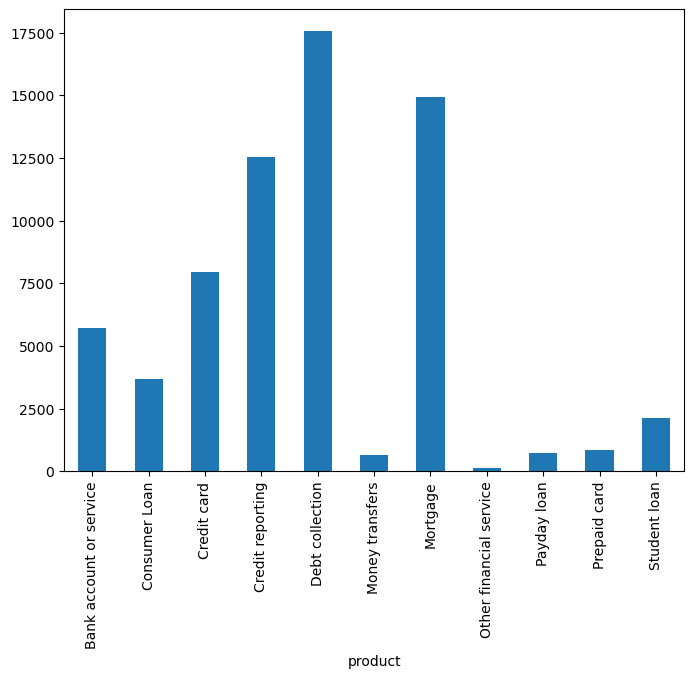

In [12]:
fig = plt.figure(figsize=(8,6))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar()
plt.show()

## Converting Text to Features

The procedure of converting raw text data into machine understandable format(numbers) is called feature engineering of text data. Machine learning and deep learning algo performance and accuracy is fundamentally dependent on the type of feature engineering techniques used.

## TF_IDF Vectorizer

TF_IDF is the most applied feature engineering technique for processing textual kind data by many machine learning expert and data scientist.

Term Frequency(TF): -> Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.
                    -> TF is basically capturing the importance of the word irrespective of the length of the document.
                    -> ex: a word with the frequency of 3 with the length of sentence being 10 is not the same as when the word length of sentence being 100 words. It should get more importance in the first scenario; that is what TF does.
  
Inverse Document Frequency(IDF): -> IDF of each word is the log of the ratio of the total number of rows to the number of rows in a 
                                    particular document in which that word is present.
                                 -> IDF will measure the rareness of a term. word like 'a' and 'the' show up in all the documents of                                           corpus, but the rare words is not in all the documents.
                                
TF-IDF is the simplest product of TF and IDF so that both of the drawbacks are addressed, which makes predictions and information retrieval relevant.

In [13]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)    # default {max_df=1.0(float) so its proportion of word contain in all documents,
# simply if a words contain in all the document it is 1.0}, {min_df=1(int) so iteger directly denotes count of words in a document shows atleast 1 word contains in a documents then only it is consider}
tfidf_vect.fit(Data['consumer_complaint_narrative'])
Features = tfidf_vect.transform(Data['consumer_complaint_narrative'])

encoder = preprocessing.LabelEncoder()
Labels1 = encoder.fit_transform(Data['product'])

# Binarize the output
#Labels = np.array(preprocessing.label_binarize(Labels, classes=[0,1,2,3,4,5,6,7,8,9,10]))

In [14]:
print(Features[0], Labels1)

  (0, 4980)	0.19946692590518458
  (0, 4967)	0.08367785689944471
  (0, 4528)	0.03945843468300431
  (0, 4486)	0.05079420833765883
  (0, 4475)	0.05074380583274784
  (0, 4466)	0.20886092796068428
  (0, 4464)	0.08214182747432149
  (0, 4462)	0.04046932892633899
  (0, 4290)	0.13501006475169727
  (0, 4063)	0.08953356522886974
  (0, 3495)	0.13173594877936717
  (0, 3270)	0.08506969605084602
  (0, 3229)	0.0916469670914765
  (0, 3210)	0.24774356329679265
  (0, 3115)	0.046174555519359825
  (0, 2845)	0.05348433820104951
  (0, 2518)	0.2246454974653814
  (0, 2449)	0.23373093275704698
  (0, 2326)	0.2000394496046405
  (0, 2305)	0.10983925924295175
  (0, 2215)	0.07212388567496104
  (0, 2200)	0.18464139378136915
  (0, 2031)	0.20026770337237787
  (0, 1994)	0.15112095802707426
  (0, 1457)	0.1633685106412558
  (0, 1199)	0.13429597623199974
  (0, 1056)	0.10694069345312737
  (0, 1011)	0.1716552590907946
  (0, 977)	0.11978819231338515
  (0, 881)	0.20696270632845382
  (0, 878)	0.08642368937977245
  (0, 762)	0.12

Next, execute the code in the cell below to split the dataset into test and training set. Notice that usually, 25% of the 100% cases are being used as the test dataset. 

In [15]:
train_x, valid_x,  train_y, valid_y = train_test_split(Data['consumer_complaint_narrative'],Data['product'])    # Default it will split 25 by 75% means 25% test case and 75% training cases

In [16]:
train_x

237321    i am a XXXX veteran so i dont need this nonsense from the csi group. and i never trusted sneaky shady uneducated debt collectors who take advantage of those who less fortunate to make a living wage in the united states. my services were provided by medical doctors at the XXXX clinic so i wish they would have dealt with me directly and stayed in contact with me so i could have paid them off in monthly installments till paid in full. i do n't think we needed to involve low life debt collectors they do not have a XXXX from a XXXX so they are not educated enough to understand how working with the company directly is the BEST option ... \n\nXXXX and possibly other credit reporting bureaus are stating i owe {$380.00} to csi group and the XXXX clinic. but i called csi and a woman named XXXX verified my balance was XXXX from back in the year 2012. you must not really understand XXXX and be behind the curveball. XXXX says they report directly from XXXX so XXXX is stating this debt is 

In [17]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
print(train_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)    # default {max_df=1.0(float) so its proportion of word contain in all documents,
# simply if a words contain in all the document it is 1.0}, {min_df=1(int) so iteger directly denotes count of words in a document shows atleast 1 word contains in a documents then only it is consider}
tfidf_vect.fit(Data['consumer_complaint_narrative'])
print(tfidf_vect.stop_words)
print(tfidf_vect.vocabulary_)
xtrain_tfidf = tfidf_vect.transform(train_x)
#print(xtrain_tfidf)
xvalid_tfidf = tfidf_vect.transform(valid_x)

[4 6 2 ... 4 3 4]
None
{'xxxx': 4967, 'has': 2215, 'claimed': 1011, 'i': 2326, 'owe': 3210, 'them': 4466, '27': 108, '00': 1, 'for': 1994, 'years': 4980, 'despite': 1457, 'the': 4462, 'proof': 3495, 'of': 3115, 'payment': 3270, 'sent': 4063, 'canceled': 881, 'check': 977, 'and': 486, 'their': 4464, 'invoice': 2518, 'they': 4475, 'continue': 1199, 'to': 4528, 'insist': 2449, 'collection': 1056, 'agencies': 420, 'are': 562, 'after': 413, 'me': 2845, 'how': 2305, 'can': 878, 'stop': 4290, 'this': 4486, 'harassment': 2200, 'a': 274, 'bill': 762, 'already': 463, 'paid': 3229, 'four': 2031, 'ago': 426, 'due': 1610, 'in': 2373, 'amount': 479, 'owed': 3211, 'that': 4460, 'was': 4836, 'told': 4531, 'by': 858, 'm': 2771, 't': 4404, 'bank': 686, 'reported': 3797, 'credit': 1285, 'reporting': 3798, 'advised': 392, 'write': 4954, 'good': 2129, 'will': 4895, 'letter': 2663, 'order': 3166, 'address': 359, 'issue': 2533, 'request': 3815, 'negative': 3019, 'entry': 1720, 'be': 714, 'removed': 3764, 'fr

In [18]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : {'filename', 'file', 'content'}, default='content'
 |      - If `'filename'`, the sequence passed as an argument to fit is
 |        expected to be a list of filenames that need reading to fetc

## Model building

Suppose we are building a linear classifier on word-level TF-IDF vectors. We are using default hyper parameters for the classifier.

In [19]:
print(xtrain_tfidf[0])

  (0, 4988)	0.09765033163882396
  (0, 4978)	0.15973259475440027
  (0, 4967)	0.3004849342412301
  (0, 4951)	0.0254488821993833
  (0, 4939)	0.050903796457146155
  (0, 4926)	0.06725229965297252
  (0, 4911)	0.07277298989600643
  (0, 4907)	0.06852680210794358
  (0, 4895)	0.06023074020218695
  (0, 4884)	0.06827157621571886
  (0, 4863)	0.02861606790183637
  (0, 4846)	0.033266537424971133
  (0, 4836)	0.017342033228534007
  (0, 4826)	0.11566153667367078
  (0, 4812)	0.08068290737610909
  (0, 4776)	0.07467100637942875
  (0, 4769)	0.05491891156765399
  (0, 4694)	0.09087037686561195
  (0, 4664)	0.07056745185797107
  (0, 4641)	0.1011676939045301
  (0, 4601)	0.08595599451247711
  (0, 4528)	0.06747341809988164
  (0, 4516)	0.07009055703099792
  (0, 4489)	0.051838417934930124
  (0, 4486)	0.08685744591119196
  :	:
  (0, 872)	0.02859593128192007
  (0, 871)	0.03146510726579593
  (0, 858)	0.0242964423901243
  (0, 852)	0.024601861067196792
  (0, 848)	0.19190609465721528
  (0, 847)	0.1002300499895504
  (0, 75

In [20]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
model

LogisticRegression()

## Model Evaluation

In [22]:
def accuracy():
    # checking accuracy
    accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf),valid_y)
    print("Accuracy: ",accuracy)
    print(metrics.classification_report(valid_y,model.predict(xvalid_tfidf), target_names=Data['product'].unique()))

accuracy()

Accuracy:  0.8508561848880374
                         precision    recall  f1-score   support

        Debt collection       0.81      0.81      0.81      1421
          Consumer Loan       0.81      0.62      0.70       921
               Mortgage       0.80      0.81      0.81      1962
            Credit card       0.86      0.87      0.86      3112
       Credit reporting       0.82      0.90      0.86      4430
           Student loan       0.77      0.55      0.64       176
Bank account or service       0.93      0.95      0.94      3693
            Payday loan       0.00      0.00      0.00        32
        Money transfers       0.70      0.30      0.42       189
Other financial service       0.84      0.67      0.74       230
           Prepaid card       0.91      0.77      0.84       536

               accuracy                           0.85     16702
              macro avg       0.75      0.66      0.69     16702
           weighted avg       0.85      0.85      0.85    

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Examine these results:
1. The overall accuracy is 0.846. However as just observed this is as somewhat misleading beacuse of some cases like `money transfer`, `payday loan`, and `other financial service` are little misclassified.
3. The class imbalance is confirmed. Of the 33, 190, 210 cases are very less than as compaire to 4370 or 3700. 
4. The precision, recall and F1 all show that Debt collection, Mortgage, Credit card, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, but the Consumer Loan, Student loan, Payday loan, Money transfers, Other financial service cases are not. As if those categories are misclassified is will directly cost to bank, beacause after going complaint to unexpected team they will not able to resolve the issues and ticket is going to send to appropriate team so, increases time range and directly impacts to customer satisfaction leads to high risk on customer relationship mangement by bank. since bank fully depends on customers they should not tollerate it.    

Let's Analyse the correctly classified and misclassified data closely by heatmap structure and confusion matrix.

[[1148    8  102   31   38   13   56    0    0   24    1]
 [  23  569   55   42  151    1   63    0   11    1    5]
 [  81   12 1597   93  155    2   19    0    0    3    0]
 [  10   31   61 2696  264    0   46    0    0    0    4]
 [  32   35   96  193 3967    4   59    0   13    0   31]
 [  53    1    8    2   12   97    1    0    0    2    0]
 [  26   16   13   52   74    0 3512    0    0    0    0]
 [  10    0    2    3   11    5    1    0    0    0    0]
 [  12   22    5    7   75    0   10    0   57    0    1]
 [  25    0   42    1    4    4    1    0    0  153    0]
 [   6    7    6   16   62    0   24    0    0    0  415]]


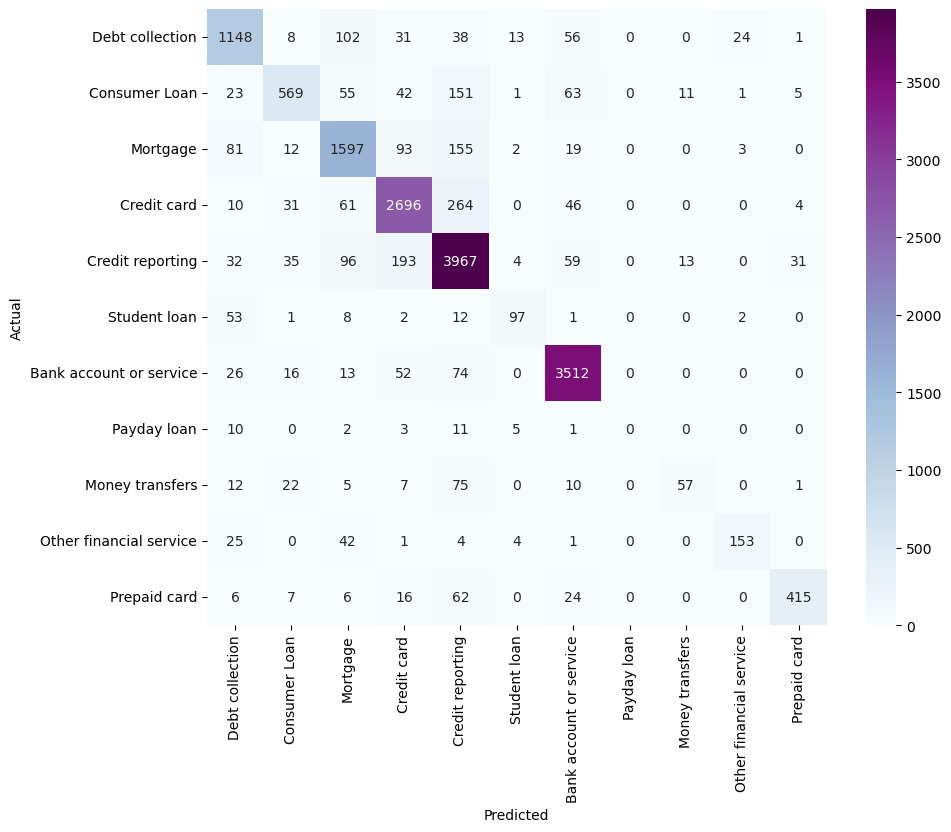

In [23]:
def heat_conf():
    # confusion matrix
    conf_mat = metrics.confusion_matrix(valid_y,model.predict(xvalid_tfidf))
    print(conf_mat)
    # visualizing confusion matrix
    #category_id_df = Data[['product','category_id']].drop_duplicates().sort_values('category_id')
    #category_id_df
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(conf_mat, annot=True,fmt='d',cmap='BuPu',xticklabels=Data['product'].unique(),yticklabels=Data['product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
heat_conf()

Examine the result:      
The confusion matrix shows the following characteristics; a) Debt collection, Mortgage, Credit card, Consumer Loan, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, b) but the Student loan, Payday loan, Money transfers, Other financial service cases are not however,

In [24]:
category_id_df = pd.DataFrame()
category_id_df['category'] = Data['product'].unique()
category_id_df['category_id'] = category_id_df.index.values

#print(category_id_df.index.values)
category_to_id = dict(category_id_df[['category_id','category']].values)
category_to_id

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

In [25]:
probabilities = model.predict_proba(xvalid_tfidf)
print(probabilities[:15,:])

[[7.65442299e-01 1.09368073e-02 2.35993901e-02 3.96357291e-02
  2.12874426e-02 7.53747711e-03 5.69473612e-02 3.47369973e-03
  4.14345105e-02 2.51943763e-02 4.51090678e-03]
 [1.13081965e-01 1.55344520e-01 8.56496237e-02 1.12983774e-01
  1.24456870e-01 4.03071763e-03 3.47098791e-01 3.34693310e-03
  2.36125374e-02 9.87452605e-03 2.05197422e-02]
 [7.72763711e-03 2.25418459e-02 6.03986994e-03 1.68192474e-02
  1.96589611e-01 2.34835862e-03 7.60663897e-03 1.39355674e-03
  9.47730278e-03 2.07390596e-03 7.27382025e-01]
 [1.90761092e-02 5.77118352e-02 8.91031348e-01 5.28043433e-03
  1.37066375e-02 4.24159460e-04 8.95153926e-03 7.08829724e-04
  5.55995762e-04 1.08249983e-03 1.47061146e-03]
 [2.80272996e-02 2.04590387e-02 5.53179461e-02 4.43512708e-01
  4.12794925e-01 5.51124721e-03 1.58613371e-02 1.67845679e-03
  6.23534957e-03 5.90010699e-03 4.70158515e-03]
 [8.70433874e-05 8.24228691e-05 3.37294586e-05 9.99669405e-01
  8.70175503e-06 1.38282332e-05 6.06877328e-05 5.11421148e-06
  6.21294845e-06

The above shows probablitic approach towards the classification problem, where the highest prob belongs to the perticular class. for ex: see the 1st row it belongs to class 3. its value ranges [0-1]

Now the below code shows that The desion_function() tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). Based on that information, the estimator then label the examples with the corresponding label.

In [26]:
y_score = model.decision_function(xvalid_tfidf)
print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
print(predictions[:15])

[[ 3.48626064e+00 -7.62059280e-01  7.02767087e-03  5.25537766e-01
  -9.60758474e-02 -1.13430567e+00  8.87934157e-01 -1.90897297e+00
   5.69920925e-01  7.24276092e-02 -1.64769500e+00]
 [ 1.02811760e+00  1.34565005e+00  7.50269519e-01  1.02724890e+00
   1.12396392e+00 -2.30605088e+00  2.14961413e+00 -2.49195088e+00
  -5.38217497e-01 -1.41003700e+00 -6.78607857e-01]
 [-4.86522678e-01  5.84047583e-01 -7.32943336e-01  2.91198096e-01
   2.74979255e+00 -1.67760919e+00 -5.02304400e-01 -2.19946653e+00
  -2.82426057e-01 -1.80189205e+00  4.05812601e+00]
 [ 1.22605822e+00  2.33308376e+00  5.07000110e+00 -5.83701548e-02
   8.95501693e-01 -2.58002432e+00  4.69446993e-01 -2.06651845e+00
  -2.30937311e+00 -1.64310549e+00 -1.33670024e+00]
 [ 3.67357779e-01  5.26035341e-02  1.04727614e+00  3.12890521e+00
   3.05712968e+00 -1.25903029e+00 -2.01936724e-01 -2.44794645e+00
  -1.13558660e+00 -1.19085076e+00 -1.41792152e+00]
 [ 4.53888266e-01  3.99344502e-01 -4.94146835e-01  9.80266147e+00
  -1.84899370e+00 -

In [27]:
# Binarize the output
y = preprocessing.label_binarize(valid_y, classes=[0,1,2,3,4,5,6,7,8,9,10])
n_classes = y.shape[1]
y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

Finally, the code in the cell below computes and displays the ROC curve and AUC. The `roc_curve` and `auc` functions from the scikit-learn `metrics` package are used to compute these values. 

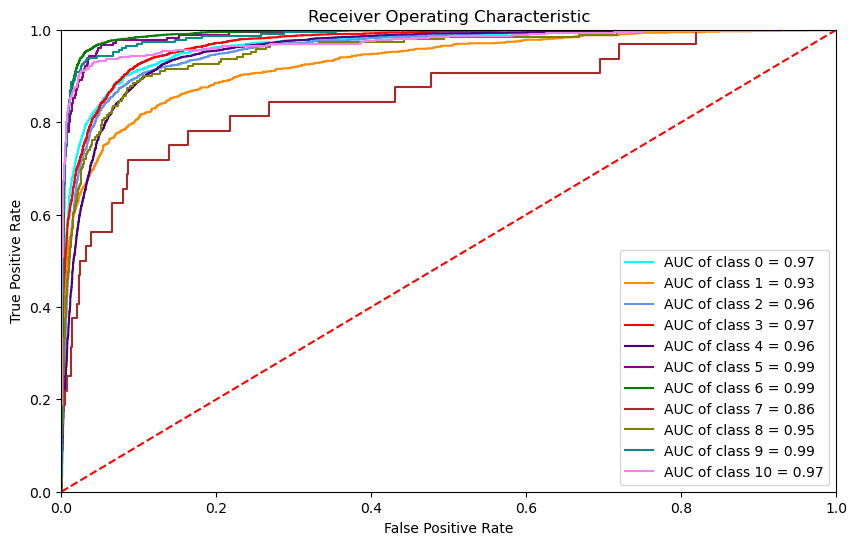

In [28]:
def plot_auc(labels, colours=['orange']):
    
    # Compute ROC curve and ROC area for each class
    n_classes = len(category_to_id)
    # print(n_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:,i], y_score[:, i])
    #     print(fpr[i], tpr[i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10,6))
    for i, color in zip(range(n_classes), colours):
        plt.plot(fpr[i], tpr[i], color = color, label = 'AUC of class {0} = {1:0.2f}'.format(i,roc_auc[i]))
        
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
 
colours = ['aqua', 'darkorange', 'cornflowerblue','r','indigo','darkmagenta','green','brown','olive','darkcyan','violet']
plot_auc(y, colours)    # in place of probabilities we can put y_score of decision function as well. will get a same result.

The above graph if for all the classified ROC curves with different colors. legends shows that all the auc are much higher and well correctly classified consumer complaints, mostly values are above 0.95 excepting some for 0.89. This curves shows that we have build a perfectly nice model as expected which is mostly classified correct complaints.

## Compute a weighted model

Recall that a falsely classifying a some categorical product customer as different category, cost high to bank and followup time to customers increses. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model. 
2. Nothing has been done to weight the results toward correctly classifying perticular product category data.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below adds a `class_weight` argument to the call to the `LogisticRegression` function. In this case weights are chosen as 5 for class 5 and 10 for class 7  but you can also give another combination. Execute this code

**Note:** default class_weights are 1 

In [29]:
# result_metric = metrics.precision_recall_fscore_support(train_y,model.predict(xtrain_tfidf))
# num_cases = result_metric[3][:]
# print(num_cases.sort())
# print(sum(num_cases))
# label_dic = {i:j for i,j in zip(num_cases,range(len(num_cases)))}
# print(label_dic)
# perc = []
# for i in range(len(num_cases)):
#     perc.append(num_cases[i]/sum(num_cases))
# perc_rev = sorted(perc,reverse=True)
# num_cases.sort()
# #print(perc_rev)
# class_weights = {label_dic[i]:j for i,j in zip(num_cases,perc_rev)}

# print(class_weights)

In [30]:
from collections import Counter
Counter(train_y)

Counter({4: 13122,
         6: 11226,
         2: 5967,
         1: 2757,
         3: 9414,
         10: 1592,
         0: 4290,
         8: 537,
         9: 631,
         5: 490,
         7: 78})

In [31]:
model = linear_model.LogisticRegression(class_weight = {8:3.0, 9:3, 5:3.0, 7:20}).fit(xtrain_tfidf, train_y)
model

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={5: 3.0, 7: 20, 8: 3.0, 9: 3})

Accuracy:  0.8518740270626273
                         precision    recall  f1-score   support

        Debt collection       0.83      0.78      0.81      1421
          Consumer Loan       0.83      0.60      0.70       921
               Mortgage       0.82      0.81      0.81      1962
            Credit card       0.86      0.87      0.86      3112
       Credit reporting       0.83      0.89      0.86      4430
           Student loan       0.65      0.69      0.67       176
Bank account or service       0.93      0.95      0.94      3693
            Payday loan       0.24      0.22      0.23        32
        Money transfers       0.52      0.52      0.52       189
Other financial service       0.79      0.80      0.80       230
           Prepaid card       0.92      0.78      0.84       536

               accuracy                           0.85     16702
              macro avg       0.75      0.72      0.73     16702
           weighted avg       0.85      0.85      0.85    

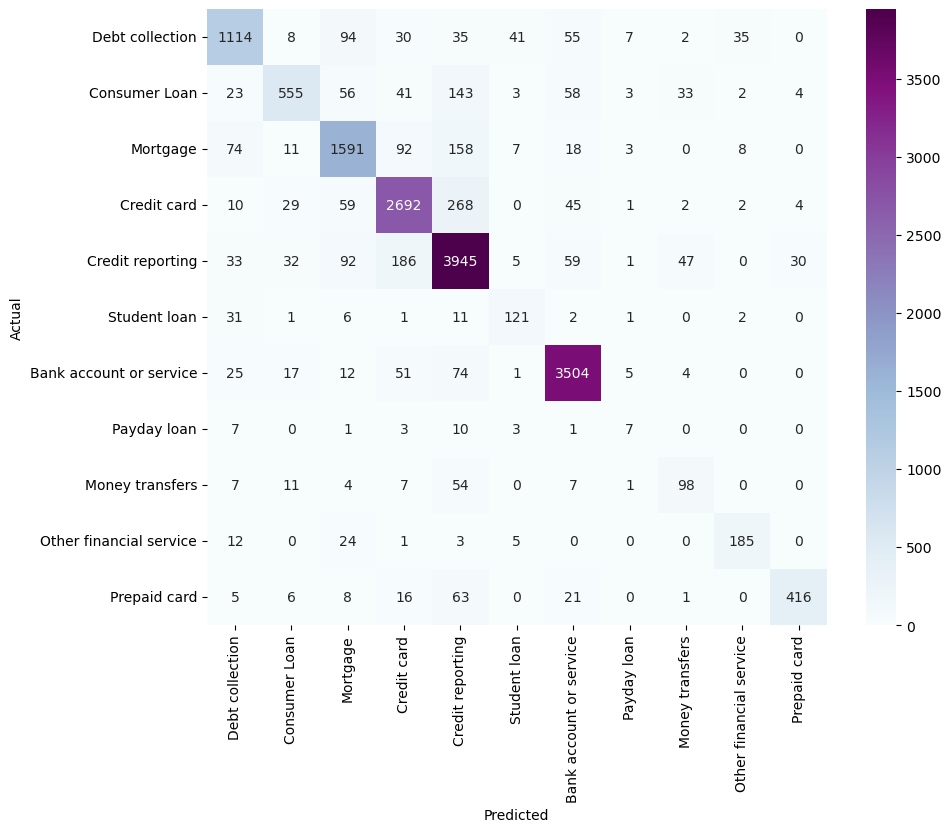

In [32]:
accuracy()
heat_conf()

In [33]:
y_score = model.decision_function(xvalid_tfidf)
print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
print(predictions[:15])

[[ 2.90652720e+00 -1.16179083e+00 -5.47135907e-01  6.71352559e-02
  -7.65340105e-01 -1.14091359e+00  5.47431415e-01 -4.28638730e-01
   2.29827394e+00  2.27534614e-01 -2.00308326e+00]
 [ 6.93191000e-01  1.11210442e+00  5.96057388e-01  9.09777237e-01
   8.53164015e-01 -2.44052061e+00  2.00492944e+00 -1.80559135e+00
   8.41325106e-03 -9.81141975e-01 -9.50382816e-01]
 [-5.06833914e-01  5.05134469e-01 -8.47905540e-01  2.40499142e-01
   2.81347441e+00 -1.54435669e+00 -4.55817685e-01 -2.27025052e+00
  -4.02244007e-02 -1.95569209e+00  4.06197283e+00]
 [ 1.07772147e+00  2.16820519e+00  4.99000511e+00 -1.25097798e-01
   7.29427185e-01 -2.88477755e+00  2.47418699e-01 -5.73192933e-01
  -2.50467326e+00 -1.64773985e+00 -1.47729627e+00]
 [ 2.34160587e-01 -1.09640923e-01  9.40945722e-01  3.05127592e+00
   2.98753210e+00 -1.03647650e+00 -3.65846107e-01 -2.40073428e+00
  -5.48278156e-01 -1.12004725e+00 -1.63289111e+00]
 [ 5.44348222e-01  4.26622125e-01 -4.62541162e-01  9.96831181e+00
  -1.66170497e+00 -

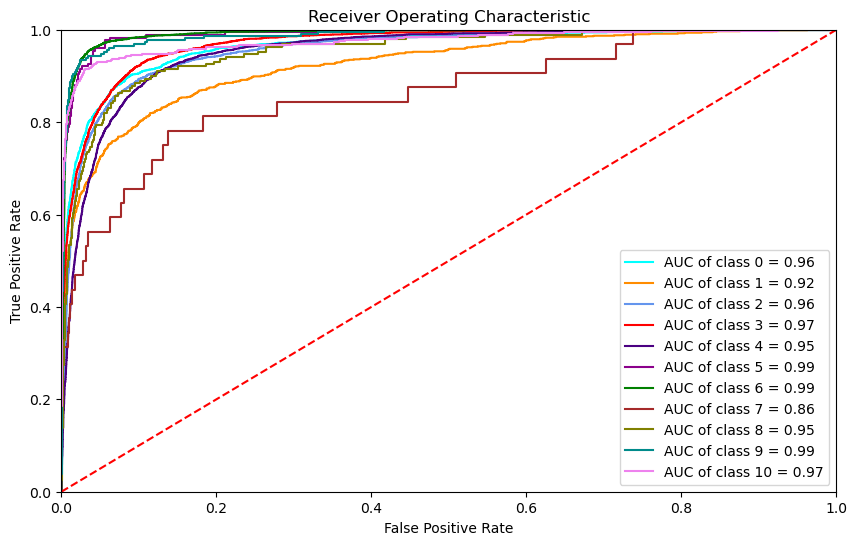

In [34]:
plot_auc(y, colours)    # in place of probabilities we can put y_score of decision function as well. will get a same result.

The accuracy is slightly changed with respect to the unweighted model. The change could be more had we give more weights to `Payday Loan`, `Money Transfers`, `Other financial services` of the class than what we did here. The precision, recall and F1 are slightly better for the these cases. Reweighting the labels has moved the results in the desired direction, at least a bit.

The trade-off between true positive and false positive is similar to the unweighted model. 

In [35]:
texts = ['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)
# print(predictions)
print(texts)
print("   -Predicted as: {}".format(category_to_id[predictions[0]]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
   -Predicted as: Credit card


## Cross validate model

To compute a better estimate of model performance, you can perform simple cross validation. The code in the cell performs the following processing:
1. Create a list of the metrics to be computed for each fold. 
2. Defines a logistic regression model object.
3. A 10 fold cross validation is performed using the `cross_validate` function from the scikit-learn `model_selection` package.

Execute this code. 

In [36]:
#Labels = Labels.reshape(Labels.shape[0])
# Binarize the output
#Labels = preprocessing.label_binarize(Labels, classes=[0,1,2,3,4,5,6,7,8,9,10])
#Labels = np.array(Labels)
print(Labels1)


scoring = ['precision_macro','recall_macro']
logistic_mod = linear_model.LogisticRegression(C = 1.0, class_weight = {8:3.0, 9:3, 5:3.0, 7:20}) 
scores = ms.cross_validate(logistic_mod, Features, Labels1, scoring=scoring,
                        cv=10, return_train_score=False)

[4 1 6 ... 8 6 6]


/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

The code in the cell below displays the performance metrics along with the mean and standard deviation, computed for each fold to the cross validation. The 'macro' versions of precision and recall are used. These macro versions average over the all the multinomial cases. 

In [37]:
def print_format(f,x,y):
    print('Fold %2d    %4.3f        %4.3f' % (f, x, y))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall')
    [print_format(f,x,y) for f,x,y in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'])]
                                              
    print('-' * 30)
    print('Mean       %4.3f        %4.3f '%
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro'])))  
    print('Std        %4.3f        %4.3f '%
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro'])))

print_cv(scores)  

         Precision     Recall
Fold  1    0.717        0.682
Fold  2    0.712        0.676
Fold  3    0.732        0.691
Fold  4    0.729        0.713
Fold  5    0.745        0.738
Fold  6    0.762        0.747
Fold  7    0.786        0.755
Fold  8    0.753        0.750
Fold  9    0.734        0.748
Fold 10    0.744        0.722
------------------------------
Mean       0.742        0.722 
Std        0.021        0.029 


Notice that there is considerable variability in each of the performance metrics from fold to fold. Even so, the standard deviations are at least an order of magnitude than the means. It is clear that **any one fold does not provide a representative value of the performance metrics**. The later is a key point as to why cross validation is important when evaluating a machine learning model.  

Compare the performance metric values to the values obtained for the baseline model you created above. In general the metrics obtained by cross validation are lower. However, the metrics obtained for the baseline model are within 1 standard deviation of the average metrics from cross validation. 

## Optimize hyperparameters with nested cross validation

Given the variability observed in cross validation, it should be clear that performing model selection from a single training and evaluation is an uncertain proposition at best. Fortunately, the nested cross validation approach provides a better way to perform model selection. However, there is no guarantee that a model selection process will, in fact, improve a model. In some cases, it may prove to be that model selection has minimal impact. 

To start the nested cross validation process it is necessary to define the randomly sampled folds for the inner and outer loops. The code in the cell below uses the `KFolds` function from the scikit-learn `model_selection` package to define fold selection objects. Notice that the `shuffle = True` argument is used in both cases. This argument specifies that a random shuffle is preformed before folds are created, ensuring that the sampling of the folds for the inside and outside loops are independent. Notice that by creating these independent fold objects there is no need to actually create nested loops for this process. 

Execute this code.

In [38]:
nr.seed(456)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(645)
outside = ms.KFold(n_splits=10, shuffle = True)

An important decision in model selection searches is the choice of performance metric used to find the best model. For classification problems scikit-learn uses accuracy as the default metric. However, as you have seen previously, accuracy is not necessarily the best metric, particularly when there is a class imbalance as is the case here. There are a number of alternatives which one could choose for such a situation. In this case AUC will be used. 

The code below uses the `inside` k-fold object to execute the inside loop of the nested cross validation. Specifically, the steps are:
1. Define a dictionary with the grid of parameter values to search over. In this case there is only one parameter, `C`, with a list of values to try. In a more general case, the dictionary can contain values from multiple parameters, creating a multi-dimensional grid that the cross validation process will iterate over. In this case there are 5 hyperparameter values in the grid and 10-fold cross validation is being used. Thus, the model will be trained and evaluated 50 times. 
2. The logistic regression model object is defined. 
3. The cross validation search over the parameter grid is performed using the `GridSearch` function from the scikit-learn `model_selection` package. Notice that the cross validation folds are computed using the `inside` k-fold object.


****
**Note:** Somewhat confusingly, the scikit-learn `LogisticRegression` function uses a regularization parameter `C` which is the inverse of the usual l2 regularization parameter $\lambda$. Thus, the smaller the parameter the stronger the regulation 
****

Execute this code.

In [39]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"estimator__C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression() 

clf_log = multiclass.OneVsRestClassifier(logistic_mod)
## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = clf_log, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

The cross validated grid search object, `clf`, has been created. 

The code in the cell below fits the cross validated model using the `fit`method. The AUC for each hyperparameter and fold is displayed as an array. Finally, the hyperparameter for the model with the best average AUC is displayed.  Execute this code and  examine the results.

In [40]:
## Fit thhe cross validated grid search over the data 
Labels = preprocessing.label_binarize(Labels1, classes=[0,1,2,3,4,5,6,7,8,9,10])
print(Labels)
clf.fit(Features, Labels)
keys = list(clf.cv_results_.keys())
print(keys)
for key in keys[6:16]:
    print(clf.cv_results_[key])


[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score']
[0.95952597 0.97027755 0.96857732 0.96035721 0.95724753]
[0.95957604 0.97113302 0.96994264 0.96362487 0.96008788]
[0.9603343  0.96901204 0.9682428  0.96100871 0.95730891]
[0.95734081 0.96777638 0.96805314 0.96152429 0.95815011]
[0.96261741 0.97292163 0.9723318  0.96250727 0.95813629]
[0.95101043 0.96451731 0.96867482 0.96214097 0.95908585]
[0.95594847 0.96683953 0.96473

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
## And print the best parameter value
clf.best_params_

{'estimator__C': 10}

The array of AUC metrics has dimensions 10 folds X  hyperparameter values. As you might expect by now, there is considerable variation in the AUC from fold to fold for each hyperparamter value, or column. 

Evidently, the optimal hyperparameter value is 10.

To help understand this behavior a bit more, the code in the cell below does the following:
1. Compute and display the mean and standard deviation of the AUC for each hyperparameter value.
2. Plot the AUC values for each fold vs. the hyperparameter values. The mean AUC for each hyperparameter value is shown with a red +. 

Execute this code and examine the results. 

In [42]:
import math
def plot_cv(clf, params_grid, param = 'estimator__C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    print(grid)
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
#     print(params*grid.shape[0])
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)    

[[0.95952597 0.97027755 0.96857732 0.96035721 0.95724753]
 [0.95957604 0.97113302 0.96994264 0.96362487 0.96008788]
 [0.9603343  0.96901204 0.9682428  0.96100871 0.95730891]
 [0.95734081 0.96777638 0.96805314 0.96152429 0.95815011]
 [0.96261741 0.97292163 0.9723318  0.96250727 0.95813629]
 [0.95101043 0.96451731 0.96867482 0.96214097 0.95908585]
 [0.95594847 0.96683953 0.96473752 0.95440389 0.94944073]
 [0.95000466 0.96196619 0.96723598 0.96309728 0.95873588]
 [0.96241591 0.97365185 0.97252061 0.96291327 0.95798377]
 [0.94806358 0.95981518 0.9580317  0.94846721 0.94292473]]
Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.10        0.95668            0.00500
    1.00        0.96779            0.00434
   10.00        0.96783            0.00393
  100.00        0.96000            0.00458
 1000.00        0.95591            0.00514


There are a number of points to notice here:
1. The mean AUC for each value of the hyperparameter are all within 1 standard deviation of each other. This result indicates that model performance is not sensitive to the choice of hyperparamter. 
2. Graphically you can see that there is a noticeable variation in the AUC from metric to metric, regardless of hyperparameter. Keep in mind that **this variation is simply a result of random sampling of the data!**

Finally, it is time to try execute the outer loop of the nested cross validation to evaluate the performance of the 'best' model selected by the inner loop. In this case, 'best' is quite approximate, since as already noted, the differences in performance between the models is not significant. 

The code in the cell below executes the outer loop of the nested cross validation using the `cross_val_scores` function from the scikit-learn `model_selection` package. The folds are determined by the `outside` k-fold object. The mean and standard deviation of the AUC is printed along with the value estimated for each fold. Execute this code and examine the result. 


In [46]:
np.random.seed(498)

# Set the number of CPU cores to use for parallel processing
n_jobs = -1  # Use all available cores, you can adjust this value if needed

# Perform cross-validation in parallel
cv_estimate = cross_val_score(clf, Features, Labels, cv=outside, n_jobs=n_jobs)

print('Mean performance metric = %4.3f' % np.mean(cv_estimate))
print('Standard deviation of the metric = %4.3f' % np.std(cv_estimate))

print('Outcomes by cv fold:')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

Mean performance metric = 0.967
Standard deviation of the metric = 0.005
Outcomes by cv fold:
Fold  1    0.970
Fold  2    0.967
Fold  3    0.974
Fold  4    0.966
Fold  5    0.973
Fold  6    0.970
Fold  7    0.959
Fold  8    0.971
Fold  9    0.959
Fold 10    0.964


As expected, there is considerable variation in AUC across the folds. However, all of these values are within 1 standard deviation of each other, and thus these differences cannot be considered significant. 

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8509759310262244
                         precision    recall  f1-score   support

        Debt collection       0.81      0.79      0.80      1421
          Consumer Loan       0.77      0.61      0.68       921
               Mortgage       0.80      0.82      0.81      1962
            Credit card       0.86      0.88      0.87      3112
       Credit reporting       0.84      0.87      0.85      4430
           Student loan       0.73      0.70      0.71       176
Bank account or service       0.93      0.94      0.94      3693
            Payday loan       0.30      0.22      0.25        32
        Money transfers       0.52      0.49      0.50       189
Other financial service       0.78      0.81      0.79       230
           Prepaid card       0.90      0.82      0.86       536

               accuracy                           0.85     16702
              macro avg       0.75      0.72      0.73     16702
           weighted avg       0.85      0.85      0.85    

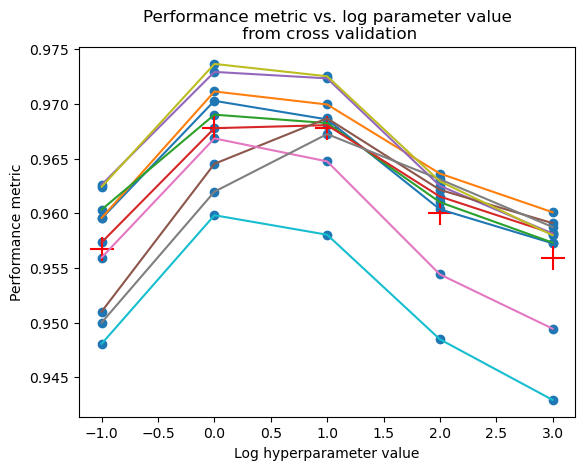

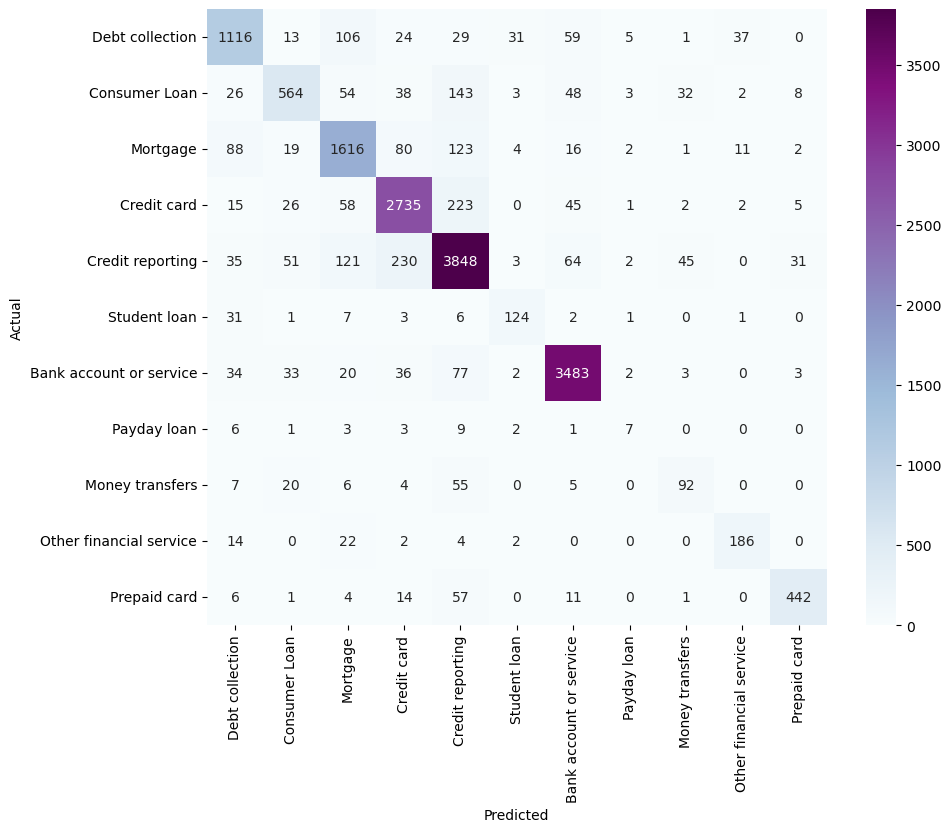

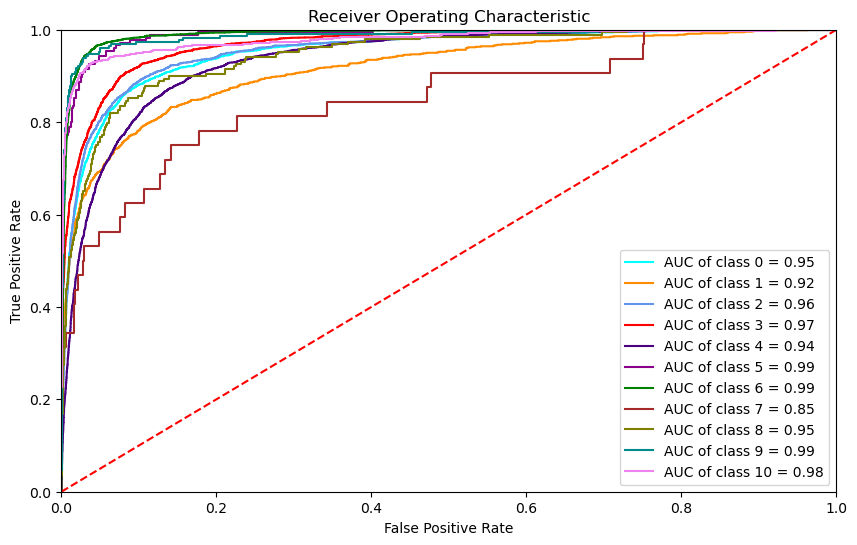

In [47]:
model = linear_model.LogisticRegression(C=10, class_weight = {8:3.0, 9:3, 5:3.0, 7:20}).fit(xtrain_tfidf, train_y)
accuracy()
heat_conf()
y_score = model.decision_function(xvalid_tfidf)
# print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
# print(predictions[:15])
    
plot_auc(y,colours) 

In [48]:
import pickle
# open a file where you want to store the data
file = open('customer_classification_model_lr.pkl','wb')
# Dump information to that file
pickle.dump(model, file)

## Support Vector machine model

Nested cross validation is used to estimate the optimal hyperparameters and perform model selection for the nonlinear SVM model. 5 fold cross validation is used since training SVMs are computationally intensive to train. Additional folds would give better estimates but at the cost of greater computation time. Execute the code in the cell below to define inside and outside fold objects. 

In [49]:
nr.seed(248)
inside = ms.KFold(n_splits=5, shuffle = True)
nr.seed(135)
outside = ms.KFold(n_splits=5, shuffle = True)

In [50]:
Labels = preprocessing.label_binarize(Labels1, classes=[0,1,2,3,4,5,6,7,8,9,10])
print(Labels)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [51]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"estimator__C": [1, 10, 100, 1000]}
## Define the SVM model
svc_clf = svm.LinearSVC() 

svc_multi_clf = multiclass.OneVsRestClassifier(svc_clf)
## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = svc_multi_clf, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
clf.fit(Features, Labels)
print(clf.best_params_)

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'estimator__C': 1}


In [52]:
plot_cv(clf, param_grid)    

[[0.96237425 0.95345318 0.94376585 0.93933104]
 [0.9640914  0.95496675 0.94500321 0.94036496]
 [0.96555233 0.95428558 0.94422557 0.93973713]
 [0.95734155 0.94535506 0.9344     0.929803  ]
 [0.95391437 0.94048582 0.92989161 0.92499845]
 [0.96065478 0.94970928 0.93945725 0.93484692]
 [0.00436265 0.0057729  0.00615038 0.00627541]
 [1.         2.         3.         4.        ]
 [0.99356322 0.99634593 0.99744053 0.99712382]
 [0.99351844 0.99634052 0.99742682 0.99707304]]
Performance metrics by parameter
Parameter   Mean performance   STD performance
    1.00        0.87554            0.29084
   10.00        0.96967            0.44662
  100.00        1.06378            0.70493
 1000.00        1.16096            0.98763


In [53]:
nr.seed(498)
cv_estimate = cross_val_score(clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/bhaskarmanojkotipalli/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean performance metric = 0.960
SDT of the metric       = 0.005
Outcomes by cv fold
Fold  1    0.961
Fold  2    0.961
Fold  3    0.969
Fold  4    0.955
Fold  5    0.956


In [54]:
model = svm.LinearSVC(class_weight={8:3.0, 9:3, 5:3.0, 7:20}).fit(xtrain_tfidf, train_y)

Accuracy:  0.8530116153754042
                         precision    recall  f1-score   support

        Debt collection       0.81      0.79      0.80      1421
          Consumer Loan       0.80      0.60      0.69       921
               Mortgage       0.80      0.82      0.81      1962
            Credit card       0.87      0.88      0.87      3112
       Credit reporting       0.84      0.89      0.86      4430
           Student loan       0.68      0.66      0.67       176
Bank account or service       0.93      0.95      0.94      3693
            Payday loan       0.25      0.09      0.14        32
        Money transfers       0.54      0.42      0.47       189
Other financial service       0.77      0.74      0.76       230
           Prepaid card       0.89      0.82      0.86       536

               accuracy                           0.85     16702
              macro avg       0.74      0.70      0.72     16702
           weighted avg       0.85      0.85      0.85    

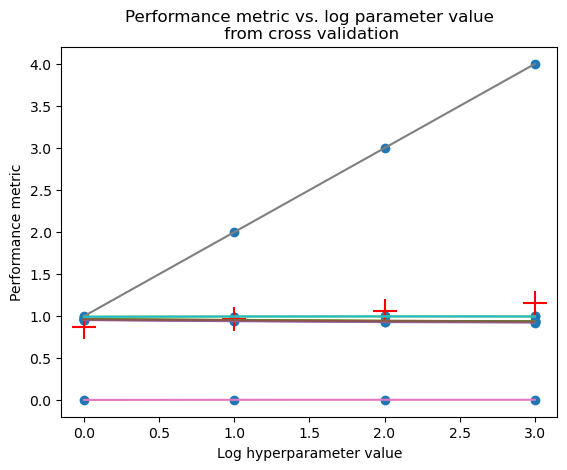

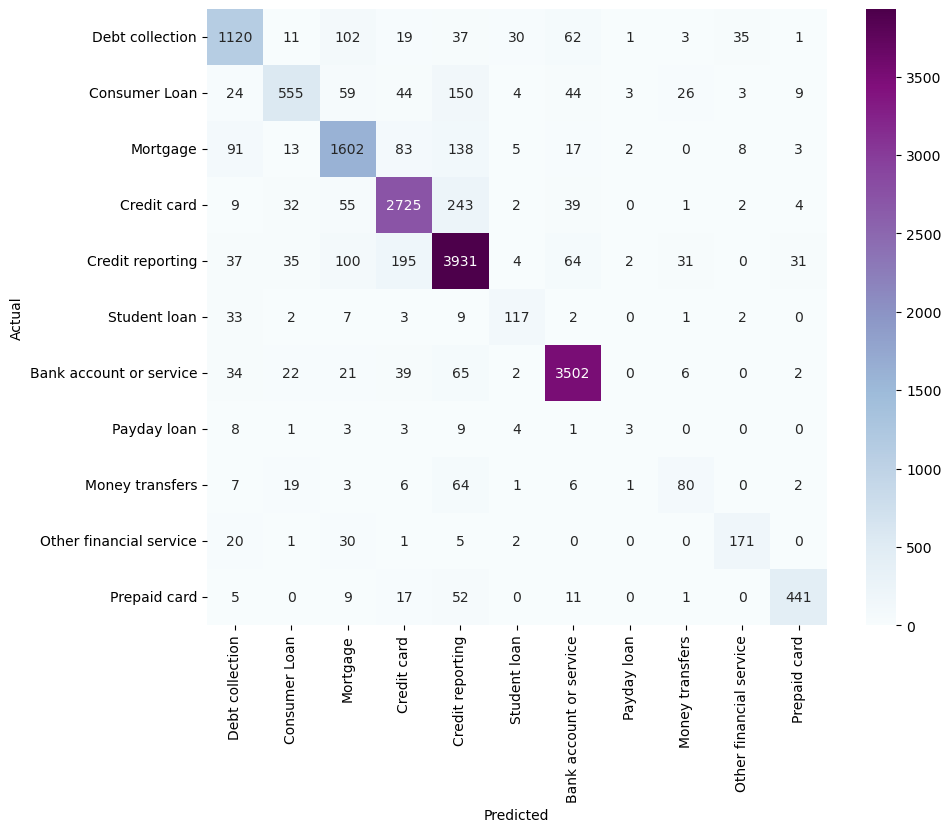

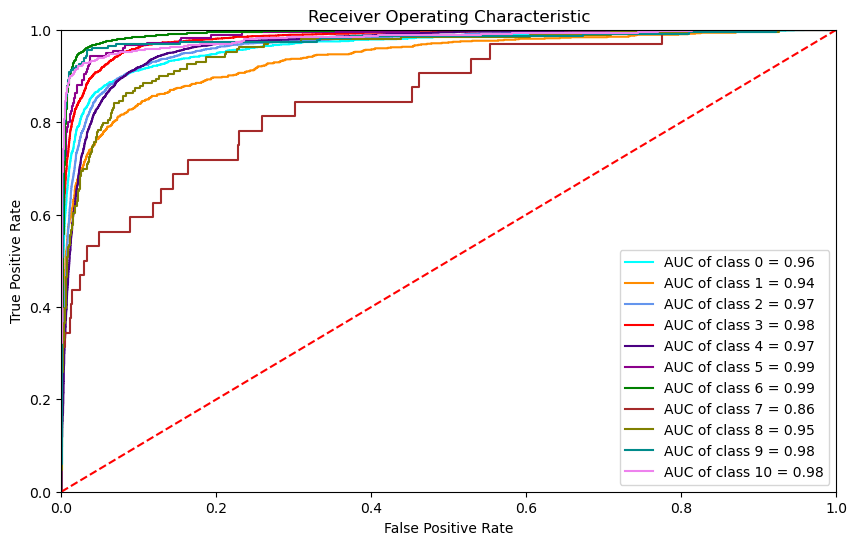

In [55]:
accuracy()
heat_conf()
y_score = model.decision_function(xvalid_tfidf)
# print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
# print(predictions[:15])
    
plot_auc(y,colours) 

In [56]:
import pickle
# open a file where you want to store the data
file = open('customer_classification_model_svm.pkl','wb')
# Dump information to that file
pickle.dump(model, file)